In [1]:
import requests
import json
import sys
import os
import xml.etree.ElementTree as ET
import time
from wpsToolsBox import wpsTB
import glob
import numpy as np

try:
    import wget
except :
    !pip install wget
    import wget
    
try:
    import rasterio
except:
    !pip install rasterio
    import rasterio


  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9680 sha256=05e85a9312043a461776666151831dcb58a62c02d25d7442f47eed9e78995b74
  Stored in directory: /projects/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
copa_backend_url = "https://gravitee-gateway.val.esa-maap.org/"
MAAP_ENV_TYPE = 'val'
user_id ='46874'
CLIENT_ID = '97262f0b-d3ca-4492-bcf8-9a0e12bdede8'

email = 'algodeveloper1@free.fr'
password = '#4yM@r4K'

url = "https://iam."+MAAP_ENV_TYPE.lower()+".esa-maap.org/oxauth/restv1/token"
response = requests.post(url, data={'client_id': CLIENT_ID, 'username': email, 'password': password, "grant_type": "password", "scope": "openid+profile"})
data = json.loads(response.text)
oauth_token = data['access_token']

In [3]:
wps = wpsTB(oauth_token, copa_backend_url, user_id)

In [4]:
wps.wps_processes()

--- Service Processes ---
There are 12 processes available for execution
 
|Identifier                | Title                
|5fe1c9ca6d8d6d0001b0e230  | readl2 
------------------------------------------------------
|5ff3301e91db790001274258  | read 
------------------------------------------------------
|5fff1388493f610001f5178d  | read-s2 
------------------------------------------------------
|5fff1388493f610001f5178b  | geocoding 
------------------------------------------------------
|5fff1388493f610001f5178a  | classification-mask 
------------------------------------------------------
|5fff1388493f610001f5178c  | s2index 
------------------------------------------------------
|5fff1388493f610001f5178e  | resample 
------------------------------------------------------
|600e8ca13d255d0001aef7c5  | reads2 
------------------------------------------------------
|600ef3b64f4c6300018f2c54  | readstwo 
------------------------------------------------------
|6011904643325f0001558fa5 

In [5]:
wps.wps_process_info('resample')

Title       : resample
Description : Resample image
Identifier  : 5fff1388493f610001f5178e


In [6]:
dir_path = '/projects/data/resample/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [7]:
!maap-s3.py list 'maap-scientific-data/shared/'

[INFO]: Start finding data in path : maap-scientific-data/shared/
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
[INFO] Result list:
maap-scientific-data/shared/
maap-scientific-data/shared/classification_geo.tif
maap-scientific-data/shared/edav/
maap-scientific-data/shared/ratio.tiff
maap-scientific-data/shared/sl/f2f_test/testoutgedi_2020.tiff
maap-scientific-data/shared/sl/gedi/gedi_path.txt
maap-scientific-data/shared/sl/gedi/gridded/rh98_1000.tiff
maap-scientific-data/shared/test.txt



In [14]:
while len(glob.glob('/projects/data/resample/ratio.tiff')) == 0:
    !maap-s3.py download 'maap-scientific-data/shared/ratio.tiff' '/projects/data/resample/ratio.tiff'
    time.sleep(5)
    
ratio_path = '/projects/data/resample/ratio.tiff'
dir_path = '/projects/data/resample/'
path_s3 = 'maap-scientific-data/shared/ratio.tiff'

In [16]:
url = "https://gravitee-gateway."+MAAP_ENV_TYPE.lower()+".esa-maap.org/s3/"+path_s3

response = requests.get(url, headers = {'Authorization': 'Bearer '+oauth_token}, allow_redirects=False)
time.sleep(5)
url_ratio = response.headers['Location']
print('url ratio :', url_ratio)

url ratio : https://maap-scientific-data.oss.eu-west-0.prod-cloud-ocb.orange-business.com:443/shared/ratio.tiff?AWSAccessKeyId=O2WPRORAGHXKBLCB6BY6&Expires=1619685377&Signature=Cg4UfWbX2WgHWlI8OnkLXT%2BH0ow%3D


In [17]:
xml_file  = '/projects/wps_notebook/xml_file/wps_resample.xml'
xml_file_out  = '/projects/wps_notebook/resample_ratio.xml'

wps.add_value(xml_file, 'size', '2', xml_file_out)
wps.add_value(xml_file_out, 'input_image', url_ratio, xml_file_out)
wps.add_value(xml_file_out, 'output', dir_path, xml_file_out)

In [23]:
jobID = wps.wps_execute_process(xml_file_out, 1)

--- EXECUTE---
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<StatusInfo xmlns:xlin="http://www.w3.org/1999/xlink" xmlns:se="http://www.opengis.net/se/2.0/core" xmlns:fes="http://www.opengis.net/fes/2.1" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:wps="http://www.opengis.net/wps/2.0" xmlns:ns2="http://www.w3.org/2005/Atom" xmlns:wms="http://www.opengis.net/wms" xmlns:ns3="urn:oasis:names:tc:ciq:xsdschema:xAL:2.0">
    <wps:JobID>608a62ebcc45e20001a25286</wps:JobID>
    <wps:Status>ACCEPTED</wps:Status>
</StatusInfo>


SUCCEEDED
Execution time was 92.77672672271729


In [25]:
response = wps.wps_result(jobID[0])

url_ratio_resample = wps.get_url(response, 'ratio_resample.npy')
print("Url ratio_resample.npy :", url_ratio_resample)

ratio_resample_path = wget.download(url_ratio_resample, '/projects/data/resample/ratio_resample.npy')

Url ratio_resample.npy : https://bmap-copa-data.oss.eu-west-0.prod-cloud-ocb.orange-business.com:443/6080499bcc45e20001a2526f/resample-2021-04-29-07-40-27-6080499bcc45e20001a2526f/ratio_resample.npy?AWSAccessKeyId=ZSTB15XXC1PDGYNVGY4Z&Expires=1619689344&Signature=4Dcn07s8HLwsF%2BR%2FRVvqXpSlMSI%3D


In [27]:
ratio_resample_arr = np.load(ratio_resample_path, allow_pickle=True)
ratio_arr = rasterio.open(ratio_path).read(1)

print("ratio shape :", ratio_arr.shape)
print("ratio resample shape :", ratio_resample_arr.shape)

ratio shape : (3875, 3325)
ratio resample shape : (7750, 6650)


Text(0.5, 1.0, 'ratio resamble (x2)')

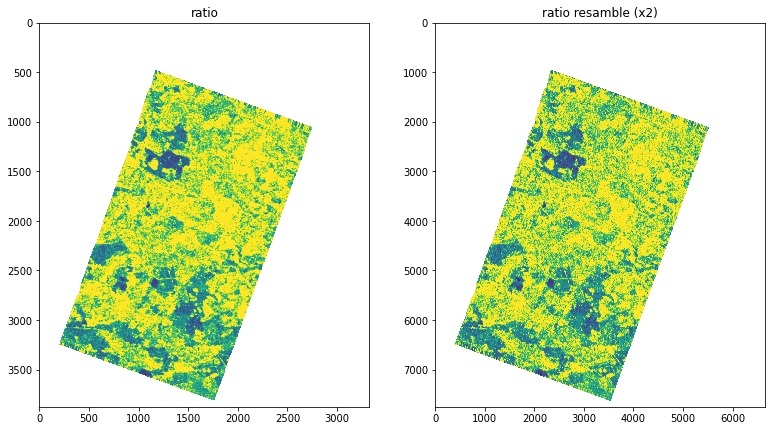

In [29]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,13))
ax1.imshow(ratio_arr, vmin=0, vmax=0.8)
ax1.set_title('ratio')
ax2.imshow(ratio_resample_arr, vmin=0, vmax=0.8)
ax2.set_title('ratio resamble (x2)')